In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

Pour simuler la gestion de nos deux populations, ING et PREPA, plusieurs choix ont dû être faits :
- génération : Nous avons décidé de gérer la génération et les temps d'arrivée de nos deux populations séparément, puis de les merge dans un dataframe global, en les ordonnant par temps d'arrivée. Leurs autre paramètres, tels que leur temps de service et de séjour, sont générés par la suite. Les deux population étant été générées séparément, cela a forcé un dédoublement des variables qui leurs sont propres, comme le taux d'arrivée et de séjour.
- proportion : Dans notre simulation, il y a autant d'ING que de PREPA, ce qui correspond globalement à la réalité (ING étant supposé avoir des pushs bien plus fréquent que PREPA, nous avons considéré que ING devait représenter ING1 seulement)
- temps d'arrivée : Pour avoir la possibilité d'observer une vraie différence entre nos population, tout en essayant de nous rapprocher de la réalité, nous avons considéré que les pushs des ING arrivaient 2 fois plus souvent que les pushs des PREPA.
- temps de séjour : De la même façon, nous avons considéré que les pushs des ING occupent les serveurs 2 fois moins longtemps que les pushs des PREPA.

In [2]:
class mmk_finite_two_populations():
    """
    Classe représentant un système de file M/M/K avec une taille de file finie, pour deux populations (ING, PREPA).

    Attributs:
        lamda_ing (float): Taux d'arrivée de la population ING
        lamda_prepa (float): Taux d'arrivée de la population PREPA
        mu_ing (float): Taux de service de la population ING
        mu_prepa (float): Taux de service de la population PREPA
        k (int): Nombre de serveurs
        Ks (int): Taille maximum de la file (SANS compter les serveurs)
        gen (np.random): Générateur de nombre random
        test_z (int): Nombre de pushes à simuler
        refused_pushes_ing (int): Pushes refusés pour la population ING
        refused_pushes_prepa (int): Pushes refusés pour la population PREPA
        tops (pd.DataFrame): données de timing pour chaque push
    """
    
    def __init__(self, lamda_ing, lamda_prepa, mu_ing, mu_prepa, k, Ks, gen, test_z=100):
        """
        Initialisation du système de file M/M/K avec une taille de file finie pour deux populations.

        Args:
            lamda_ing: Taux d'arrivée de la population ING
            lamda_prepa: Taux d'arrivée de la population PREPA
            mu_ing: Taux de service de la population ING
            mu_prepa: Taux de service de la population PREPA
            k: Nombre de serveurs
            Ks: Taille maximum de la file (SANS compter les serveurs)
            gen: Générateur de nombre random
            test_z: Nombre de pushes à simuler
        """
        # Paramètres de la file
        self.lamda_ing = lamda_ing
        self.lamda_prepa = lamda_prepa
        self.mu_ing = mu_ing
        self.mu_prepa = mu_prepa
        self.k = k
        self.Ks = Ks
        self.gen = gen
        self.t_size = test_z
        self.refused_pushes_ing = 0
        self.refused_pushes_prepa = 0
        
        # Initialisation du Dataframe temporel
        self.tops = pd.DataFrame(
            index=range(test_z),
            columns=['t_arrival', 't_service_start', 't_departure', 'population'],
            data=np.zeros((test_z, 4))
        )
        
    def run(self):
        """
        Simule le système de file M/M/K avec une taille finie pour deux populations.
        """
        print("Lancement de la simulation M/M/K pour deux populations")
        
        # Ajout des colonnes temporelles
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)

        # Ajout de la colonne pour traquer le nombre de rejet
        self.tops["rejected"] = np.zeros(self.t_size)
        
        # Traque la disponibilité des serveurs
        server_available = np.zeros(self.k)
        
        # Gènère les temps d'arrivée pour les deux population
        arrivals_ing = np.cumsum(self.gen.exponential(1 / self.lamda_ing, self.t_size // 2))
        arrivals_prepa = np.cumsum(self.gen.exponential(1 / self.lamda_prepa, self.t_size // 2))
        
        # Merge et tri des temps d'arrivée + ajout des labels de population
        arrivals = np.concatenate((arrivals_ing, arrivals_prepa))
        populations = ['ING'] * len(arrivals_ing) + ['PREPA'] * len(arrivals_prepa)
        combined = sorted(zip(arrivals, populations))
        
        # Traitement des pushs
        for i, (arrival_time, population) in enumerate(combined):
            self.tops.loc[i, "t_arrival"] = arrival_time
            self.tops.loc[i, "population"] = population
            
            # Compte les pushs actuellement dans la file
            current_time = arrival_time
            in_queue = ((self.tops["t_arrival"] <= current_time) & 
                       (self.tops["t_service_start"] > current_time)).sum()
            
            # Vérifie si la limite de taille de la file d'attente est atteinte
            if in_queue >= self.Ks:
                if population == 'ING':
                    self.refused_pushes_ing += 1
                else:
                    self.refused_pushes_prepa += 1
                self.tops.loc[i, "rejected"] = 1
                continue
                
            # Trouve le premier serveur disponible
            server_idx = np.argmin(server_available)
            
            # Calcule le début du temps de service
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], arrival_time)
            
            # Calcule le temps d'attente et de service
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - arrival_time
            if population == 'ING':
                self.tops.loc[i, "t_service"] = self.gen.exponential(1 / self.mu_ing)
            else:
                self.tops.loc[i, "t_service"] = self.gen.exponential(1 / self.mu_prepa)
            
            # Calcule le temps de départ
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]
            
            # Met à jour la disponibilité des serveurs
            server_available[server_idx] = self.tops.loc[i, "t_departure"]

    def counts(self, t_intervals, population= "BOTH"):
        """
        Calcule le nombre de push dans le système à des intervalles de temps régulier
        
        Args:
            t_intervals: L'intervalle de temps pour les mesures
            population: Le type de population étudiée (BOTH pour les deux, PREPA ou ING pour l'étude d'une population en particulier)
            
        Returns:
            Dataframe avec le nombre de push dans le système, dans la file d'attente, en service et rejeté
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)
        last_t = 0
        
        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service', 'rejected'],
            data=np.zeros((len(t_points), 4))
        )

        if (population == "BOTH"):
            for t in t_points:
                in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
                in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
                in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()
                rejected = ((self.tops["t_arrival"] <= t) & (self.tops["t_arrival"] > last_t) & (self.tops["rejected"] == 1)).sum()
                
                counts.loc[t] = [in_sys, in_queue, in_service, rejected]
                last_t = t
        
        else:
            filtered_tops = self.tops[self.tops["population"] == population]

            for t in t_points:
                in_sys = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_departure"] > t)).sum()
                in_queue = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_service_start"] > t)).sum()
                in_service = ((filtered_tops["t_service_start"] <= t) & (filtered_tops["t_departure"] > t)).sum()
                rejected = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_arrival"] > last_t) & (filtered_tops["rejected"] == 1)).sum()
                
                counts.loc[t] = [in_sys, in_queue, in_service, rejected]
                last_t = t
        return counts
    
    def stats(self):
        """
        Crèe un résumé de statistiques pour les deux populations.
        
        Returns:
            Dataframe avec des statistiques pour chaque population
        """
        stats_ing = self.tops[self.tops["population"] == 'ING'][["t_waiting", "t_service", "t_sojourn"]].mean()
        stats_prepa = self.tops[self.tops["population"] == 'PREPA'][["t_waiting", "t_service", "t_sojourn"]].mean()
        
        stats = pd.DataFrame({
            'Population': ['ING', 'PREPA'],
            'Mean Waiting Time': [stats_ing["t_waiting"], stats_prepa["t_waiting"]],
            'Mean Service Time': [stats_ing["t_service"], stats_prepa["t_service"]],
            'Mean Sojourn Time': [stats_ing["t_sojourn"], stats_prepa["t_sojourn"]],
            'Refused Pushes': [self.refused_pushes_ing, self.refused_pushes_prepa]
        })
        
        return stats

In [3]:
class mm1_finite():
    """
    Classe représentant un système de file M/M/1 avec une taille de file finie pour traiter les résultats des étudiants

    Attributs:
        lamda (float): Taux d'arrivée des résultats
        mu (float): Taux de service du serveur
        gen (np.random): Générateur de nombre random
        test_z (int): Nombre de pushes à simuler
        Kf (int): Taille maximum de la file (SANS compter les serveurs)
        tops (pd.DataFrame): Dataframe contenant les données temporelles pour chaque résultat
        refused_pushes (int): Compteur pour les pushs refusés à cause de la capacitée finie de la file
    """
    
    def __init__(self, lamda, mu, gen, Kf, test_z=100, previous_tops=None):
        """
        Initialise le système de file M/M/1 avec une capacité finie
        
        Args:
            lamda: Taux d'arrivée des résultats
            mu: Taux de service du serveur
            gen: Générateur de nombre random
            Kf: Taille maximum de la file (SANS compter les serveurs)
            test_z: Nombre de pushes à simuler
        """
        # Paramètres de la file
        self.lamda = lamda
        self.mu = mu
        self.k = 1
        self.Kf = Kf
        self.gen = gen
        self.t_size = test_z
        self.refused_pushes = 0
        
        # Initialise le dataframe de temporalité
        if previous_tops is None:
            self.tops = pd.DataFrame(
                index=range(test_z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((test_z, 3))
            )
        else:
            self.tops = previous_tops
        
    def run(self):
        """
        Simule le système de file M/M/1 avec une capacité finie.

        Pour chaque résultat:
        1. Génère le temps d'arrivée grâce à un temps d'interarrivée exponentielle.
        2. Vérifie si la capacité de la file d'attente est dépassée.
        3. Trouve le premier serveur disponible (s'il n'est pas refusé).
        4. Genère le temps de service avec une distribution exponentielle.
        5. Calcule le temps de départ
        
        Calcule également le temps d'attente, le temps de service et le temps de séjour total pour chaque résultat
        """
        print("Lancement de la simulation de la file M/M/1 avec une caoacité finie")
        
        # Ajout des colonnes de temps
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)
        
        # Traque la disponibilité des serveurs
        server_available = np.zeros(self.k)
        
        # Traitement des premiers résultats
        self.tops.loc[0, "t_service"] = self.gen.exponential(1/self.mu)
        self.tops.loc[0, "t_service_start"] = self.tops.loc[0, "t_arrival"]
        self.tops.loc[0, "t_waiting"] = 0.0
        self.tops.loc[0, "t_departure"] = self.tops.loc[0, "t_service_start"] + self.tops.loc[0, "t_service"]
        self.tops.loc[0, "t_sojourn"] = self.tops.loc[0, "t_waiting"] + self.tops.loc[0, "t_service"]
        server_available[0] = self.tops.loc[0, "t_departure"]
        
        # Traitement des autres résultats
        for i in range(1, self.t_size):
            # Check queue capacity
            in_queue = ((self.tops["t_arrival"] <= self.tops.loc[i, "t_arrival"]) & 
                       (self.tops["t_service_start"] > self.tops.loc[i, "t_arrival"])).sum()
            
            if in_queue >= self.Kf:
                self.refused_pushes += 1
                continue
                
            # Trouve le premier serveur disponible
            server_idx = np.argmin(server_available)
            
            # Calcule le temps du début du service
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], self.tops.loc[i, "t_arrival"])
            
            # Calcule le temps d'attente et de service
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - self.tops.loc[i, "t_arrival"]
            self.tops.loc[i, "t_service"] = self.gen.exponential(1/self.mu)
            
            # Calcule le temps de départ
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]
            
            # Met à jour la disponibilité des serveurs
            server_available[server_idx] = self.tops.loc[i, "t_departure"]
    
    def counts(self, t_intervals):
        """
        Calcule le nombre de résultats dans le système à un intervalle de temps régulier.
        
        Args:
            t_intervals: L'intervalle de temps pour la prise de mesure
            
        Returns:
            Dataframe avec le nombre de résultats dans le système, dans la file d'attente et en service.
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)
        
        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service'],
            data=np.zeros((len(t_points), 3))
        )
        
        for t in t_points:
            in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
            in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
            in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()
            
            counts.loc[t] = [in_sys, in_queue, in_service]
            
        return counts

    def stats(self):
        """
        Crèe un résumé des statistiques pour la simulation de la file.
        
        Returns:
            Dataframe avec un temps moyen de séjour, d'attente, de service et le nombre de résultats refusés.
            Les temps de départ et d'arrivée sont également présents.
        """
        # Calcule les statistiques moyennes
        stats = pd.DataFrame(
            index=['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 'refused_pushes'],
            columns=['value'],
            data=[
                self.tops["t_sojourn"].mean(),
                self.tops["t_waiting"].mean(), 
                self.tops["t_service"].mean(),
                self.refused_pushes
            ]
        )
        
        # Ajoute le temps d'arrivée et de départ
        arrivals_departures = pd.DataFrame({
            'Arrival Time': self.tops["t_arrival"],
            'Departure Time': self.tops["t_departure"]
        })
        
        return stats, arrivals_departures

Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'PREPA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation de la file M/M/1 avec une caoacité finie

Statistiques de la file M/M/K:
  Population  Mean Waiting Time  Mean Service Time  Mean Sojourn Time  \
0        ING           0.028309           0.408880           0.437189   
1      PREPA           0.017761           0.836956           0.854717   

   Refused Pushes  
0               4  
1               1  

Statistiques de la file M/M/1:
(                        value
mean_sojourn_time   10.665137
mean_waiting_time   10.306745
mean_service_time    0.358392
refused_pushes     771.000000,       Arrival Time  Departure Time
0         0.529900        0.728399
1         1.359172        1.581327
2         3.486026        3.710995
3         3.006515        4.745597
4         4.278414        4.754743
...            ...             ...
4995   2385.216431     2385.653499
4996   2385.398334     2386.144265
4997   2387.502109     2387.561170
4998   2387.687519     2387.805480
4999   2388.375185     2388.389739

[5000 rows x 2 

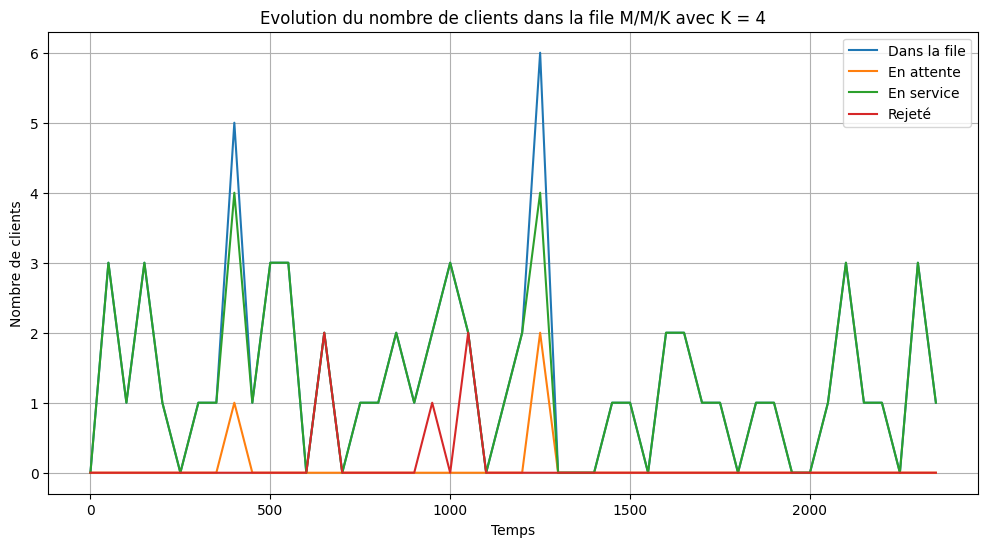

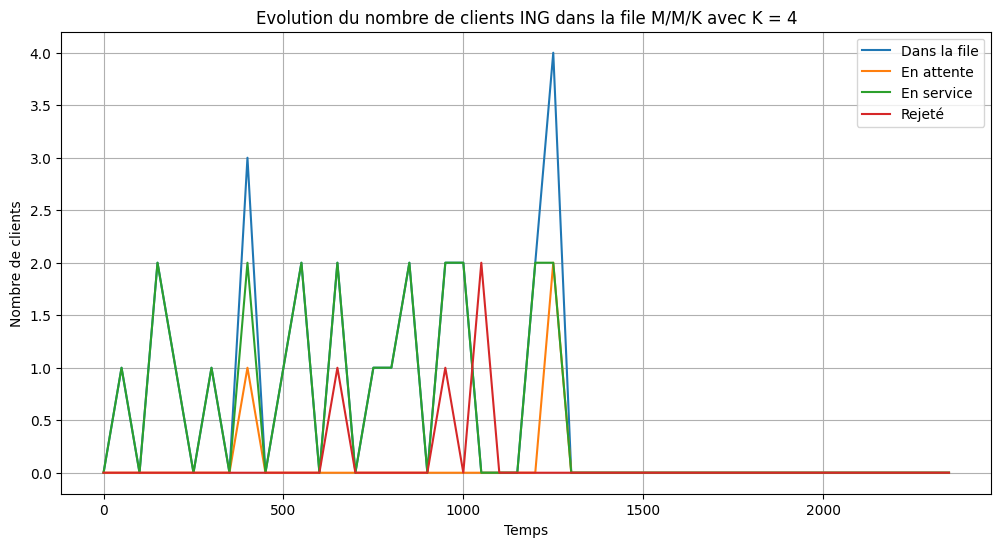

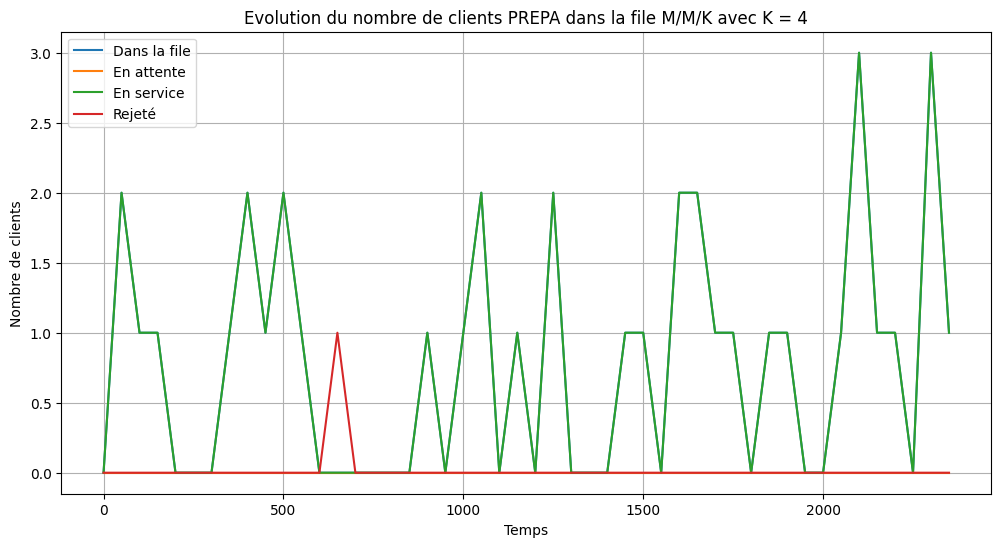

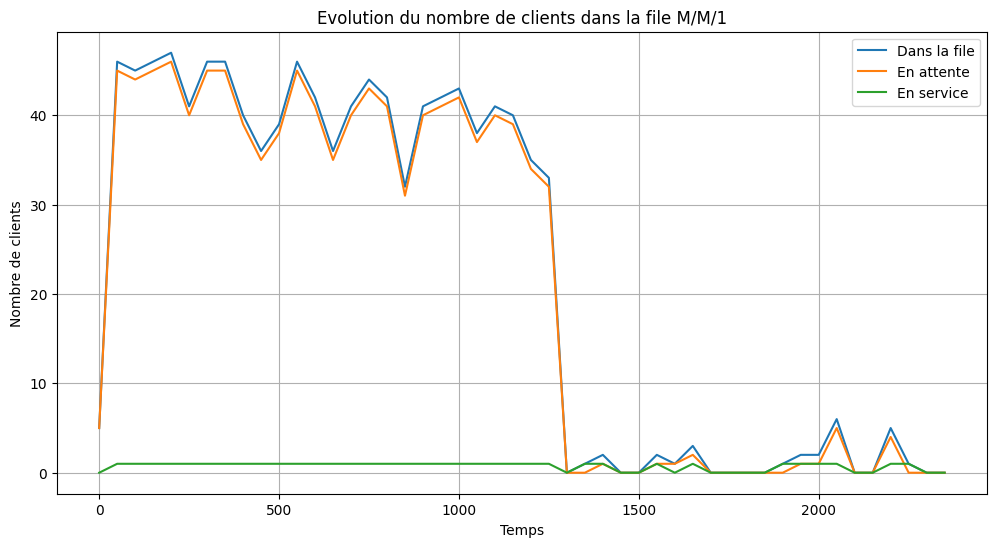

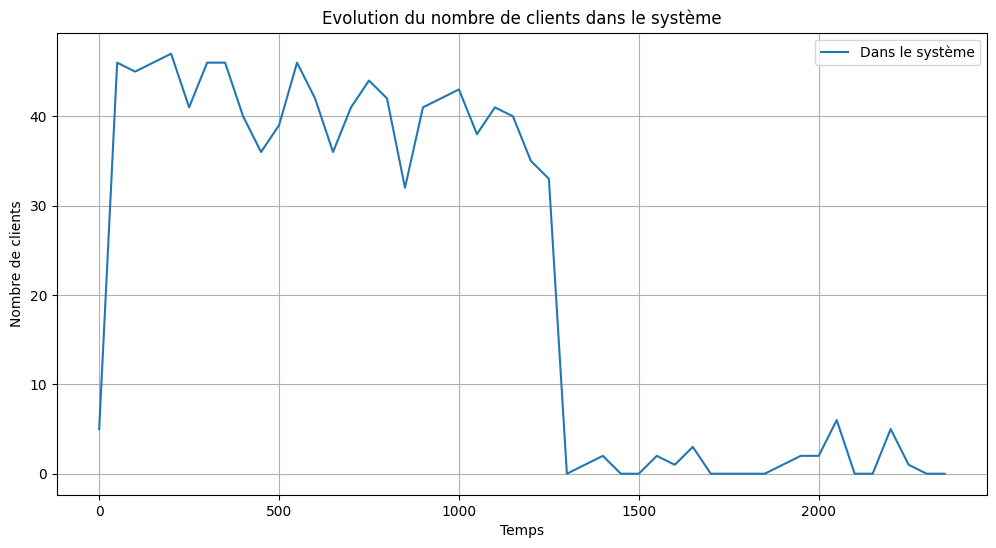

In [4]:
# Paramètres de la file M/M/K
lambda_arr_ing = 2.0  # Taux d'arrivée des pushs population ing
lambda_arr_prepa = 1.0 # Taux d'arrivée des pushs population prepa
mu_1_ing = 2.4 # Taux de service des serveurs population ing
mu_1_prepa = 1.2 # Taux de service des serveurs population prepa
K = 4            # Nombre de serveurs
gen = np.random.default_rng(seed=42)
z = 5000
Ks = 5 # Taille maximale de la file pour M/M/K (SANS le nombre de serveurs)

# Paramètres de la file M/M/1
lambda_arr_2 = 1.0  # Taux d'arrivée des pushs
mu_2 = 2.4       # Taux de service du serveur
Kf = 40 # Taille maximale de la file pour M/M/1 (SANS le nombre de serveurs)

# Créer une instance de la file M/M/K
mmk_queue = mmk_finite_two_populations(lamda_ing=lambda_arr_ing, lamda_prepa=lambda_arr_prepa,mu_ing=mu_1_ing, mu_prepa=mu_1_prepa, k=K, Ks=Ks, gen=gen, test_z=z)

# Simuler la file d'attente
mmk_queue.run()

prev_tops = pd.DataFrame(
                index=range(z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((z, 3))
            )
prev_tops["t_arrival"] = mmk_queue.tops["t_departure"]

# Créer une instance de la file M/M/1
mm1_queue = mm1_finite(lamda=lambda_arr_2, mu=mu_2, gen=gen, Kf=Kf, test_z=z, previous_tops=prev_tops)

# Simuler la file d'attente
mm1_queue.run()

# Afficher les statistiques
print("\nStatistiques de la file M/M/K:")
print(mmk_queue.stats())

print("\nStatistiques de la file M/M/1:")
print(mm1_queue.stats())

# Calculer les comptages à intervalles réguliers pour la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50,)

# Tracer l'évolution du nombre de clients dans la file M/M/K
plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.plot(counts_df_k.index, counts_df_k['rejected'], label='Rejeté')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients ing dans la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50, population="ING")

plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.plot(counts_df_k.index, counts_df_k['rejected'], label='Rejeté')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients ING dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients prepa dans la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50, population="PREPA")

plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.plot(counts_df_k.index, counts_df_k['rejected'], label='Rejeté')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients PREPA dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Calculer les comptages à intervalles réguliers pour la file M/M/1
counts_df_1 = mm1_queue.counts(t_intervals=50)

# Tracer l'évolution du nombre de clients dans la file M/M/1
plt.figure(figsize=(12, 6))
plt.plot(counts_df_1.index, counts_df_1['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_1.index, counts_df_1['ag_in_queue'], label='En attente')
plt.plot(counts_df_1.index, counts_df_1['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/1')
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients dans le système
plt.figure(figsize=(12, 6))
plt.plot(counts_df_1.index, counts_df_1['ag_in_sys'], label='Dans le système')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans le système')
plt.legend()
plt.grid(True)
plt.show()


5 meilleurs configurations:
     k  Ks  mu_ing  mu_prepa  ing_sojourn  prepa_sojourn  ing_refused  \
224  3   6     3.6       1.8     0.303248       0.547395            0   
244  3   7     3.2       1.8     0.323743       0.557603            0   
249  3   7     3.6       1.8     0.308349       0.582129            0   
219  3   6     3.2       1.8     0.333423       0.566199            0   
243  3   7     3.2       1.6     0.355734       0.638570            0   

     prepa_refused  utilization  efficiency_score  
224              0     0.370370         -3.850643  
244              0     0.400000         -3.881345  
249              0     0.370370         -3.890478  
219              0     0.400000         -3.899621  
243              0     0.416667         -3.994304  


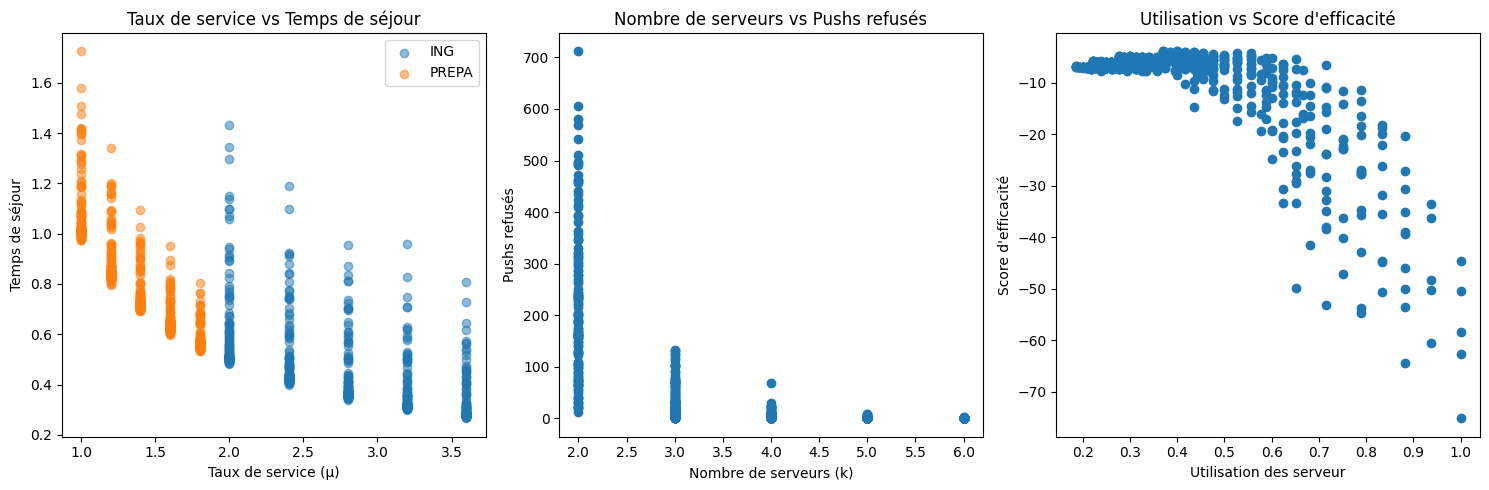

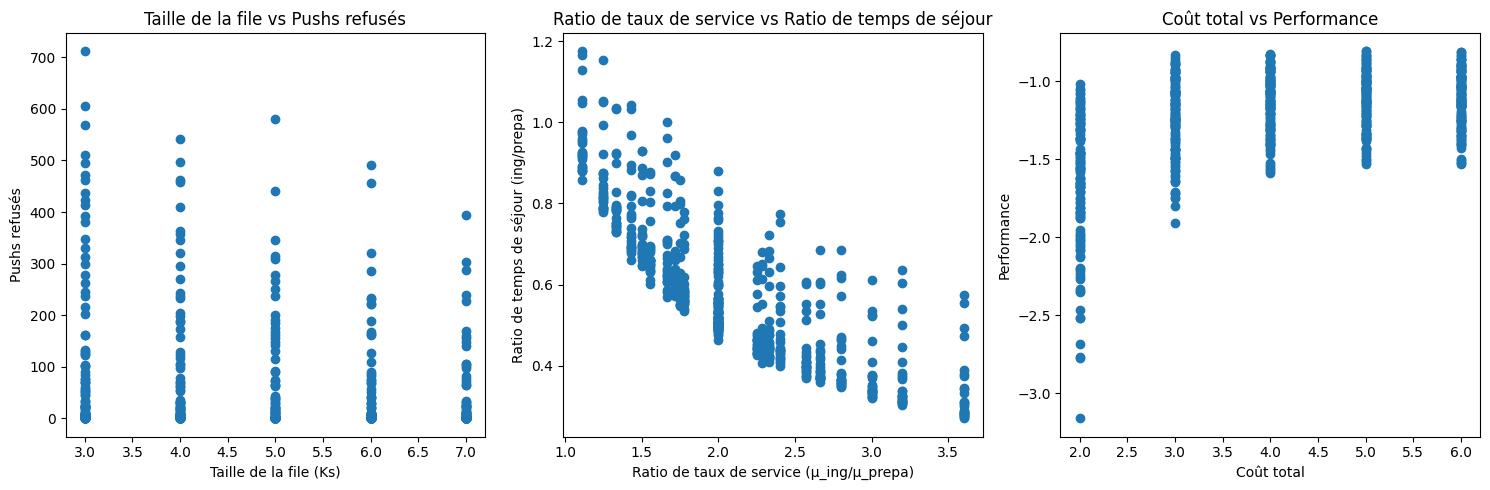

In [5]:
def optimize_parameters(base_lambda_ing, base_lambda_prepa, 
                       mu_ing_range, mu_prepa_range, 
                       k_range, ks_range, 
                       test_z=5000):
    """
    Trouver les paramètres optimaux en testant différentes combinaisons.

    Args:
        base_lambda_ing/prepa: Taux d'arrivée fixe (supposé basé sur le système réel)
        mu_ing_range/mu_prepa_range: Plage de taux de service à tester
        k_range: Plage de nombres de serveurs à tester
        ks_range: Plage de tailles de file à tester  (SANS le nombre de serveurs)
        test_z: Nombre de simulations
    
    Retournes:
        DataFrame avec les résultats et les meilleures configurations
    """
    results = []
    gen = np.random.default_rng(seed=42)
    
    for k in k_range:
        for ks in ks_range:
            for mu_ing in mu_ing_range:
                for mu_prepa in mu_prepa_range:
                    # Lance la simulation
                    mmk_queue = mmk_finite_two_populations(
                        lamda_ing=base_lambda_ing,
                        lamda_prepa=base_lambda_prepa,
                        mu_ing=mu_ing,
                        mu_prepa=mu_prepa,
                        k=k,
                        Ks=ks,
                        gen=gen,
                        test_z=test_z
                    )
                    mmk_queue.run()
                    stats = mmk_queue.stats()

                    clear_output(wait=True)
                    
                    # Calculer les statistiques pour chaque population
                    ing_stats = stats[stats['Population'] == 'ING'].iloc[0]
                    prepa_stats = stats[stats['Population'] == 'PREPA'].iloc[0]
                    
                    # Calculer l'utilisation du serveur
                    total_arrival_rate = base_lambda_ing + base_lambda_prepa
                    avg_service_rate = (mu_ing + mu_prepa) / 2
                    utilization = total_arrival_rate / (k * avg_service_rate)
                    
                    results.append({
                        'k': k,
                        'Ks': ks,
                        'mu_ing': mu_ing,
                        'mu_prepa': mu_prepa,
                        'ing_sojourn': ing_stats['Mean Sojourn Time'],
                        'prepa_sojourn': prepa_stats['Mean Sojourn Time'],
                        'ing_refused': ing_stats['Refused Pushes'],
                        'prepa_refused': prepa_stats['Refused Pushes'],
                        'utilization': utilization,
                        'total_cost': k  # Coût total (proportionnel au nombre de serveurs)
                    })
    
    results_df = pd.DataFrame(results)
    
    # Trouver le score d'efficacité pour chaque configuration
    results_df['efficiency_score'] = (
        -results_df['ing_sojourn'] 
        - results_df['prepa_sojourn'] 
        - 0.1 * (results_df['ing_refused'] + results_df['prepa_refused'])
        - results_df['total_cost']
    )
    
    return results_df

# Recherche des paramètres optimaux
k_range = [2, 3, 4, 5, 6]
ks_range = [3, 4, 5, 6, 7]
mu_ing_range = [2.0, 2.4, 2.8, 3.2, 3.6]
mu_prepa_range = [1.0, 1.2, 1.4, 1.6, 1.8]

optimization_results = optimize_parameters(
    base_lambda_ing=2.0,
    base_lambda_prepa=1.0,
    mu_ing_range=mu_ing_range,
    mu_prepa_range=mu_prepa_range,
    k_range=k_range,
    ks_range=ks_range
)

# Montre les 5 meilleures configurations
print("\n5 meilleurs configurations:")
print(optimization_results.nlargest(5, 'efficiency_score')[
    ['k', 'Ks', 'mu_ing', 'mu_prepa', 'ing_sojourn', 'prepa_sojourn', 
     'ing_refused', 'prepa_refused', 'utilization', 'efficiency_score']
])

# Visualisation des résultats
plt.figure(figsize=(15, 5))

# Plot 1: Taux de service vs temps de séjour
plt.subplot(1, 3, 1)
plt.scatter(optimization_results['mu_ing'], 
           optimization_results['ing_sojourn'],
           alpha=0.5, label='ING')
plt.scatter(optimization_results['mu_prepa'], 
           optimization_results['prepa_sojourn'],
           alpha=0.5, label='PREPA')
plt.xlabel('Taux de service (μ)')
plt.ylabel('Temps de séjour')
plt.title('Taux de service vs Temps de séjour')
plt.legend()

# Plot 2: Nombre de serveurs vs pushs refusés
plt.subplot(1, 3, 2)
plt.scatter(optimization_results['k'], 
           optimization_results['ing_refused'] + optimization_results['prepa_refused'])
plt.xlabel('Nombre de serveurs (k)')
plt.ylabel('Pushs refusés')
plt.title('Nombre de serveurs vs Pushs refusés')

# Plot 3: Utilisation des serveur vs score d'efficacité
plt.subplot(1, 3, 3)
plt.scatter(optimization_results['utilization'], 
           optimization_results['efficiency_score'])
plt.xlabel('Utilisation des serveur')
plt.ylabel('Score d\'efficacité')
plt.title('Utilisation vs Score d\'efficacité')

plt.tight_layout()
plt.show()

# Analyses additionnelles
plt.figure(figsize=(15, 5))

# Plot 1: Taille de la file vs pushs refusés
plt.subplot(1, 3, 1)
plt.scatter(optimization_results['Ks'], 
           optimization_results['ing_refused'] + optimization_results['prepa_refused'])
plt.xlabel('Taille de la file (Ks)')
plt.ylabel('Pushs refusés')
plt.title('Taille de la file vs Pushs refusés')

# Plot 2: Ratio de taux de service vs ratio de temps de séjour
optimization_results['service_rate_ratio'] = optimization_results['mu_ing'] / optimization_results['mu_prepa']
optimization_results['sojourn_time_ratio'] = optimization_results['ing_sojourn'] / optimization_results['prepa_sojourn']

plt.subplot(1, 3, 2)
plt.scatter(optimization_results['service_rate_ratio'],
           optimization_results['sojourn_time_ratio'])
plt.xlabel('Ratio de taux de service (μ_ing/μ_prepa)')
plt.ylabel('Ratio de temps de séjour (ing/prepa)')
plt.title('Ratio de taux de service vs Ratio de temps de séjour')

# Plot 3: Coût total vs performance
optimization_results['performance'] = -(optimization_results['ing_sojourn'] + optimization_results['prepa_sojourn'])
plt.subplot(1, 3, 3)
plt.scatter(optimization_results['total_cost'],
           optimization_results['performance'])
plt.xlabel('Coût total')
plt.ylabel('Performance')
plt.title('Coût total vs Performance')

plt.tight_layout()
plt.show()

Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'PREPA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'PREPA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'PREPA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation M/M/K pour deux populations


C:\Users\Eliana\AppData\Local\Temp\ipykernel_23200\825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ING' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


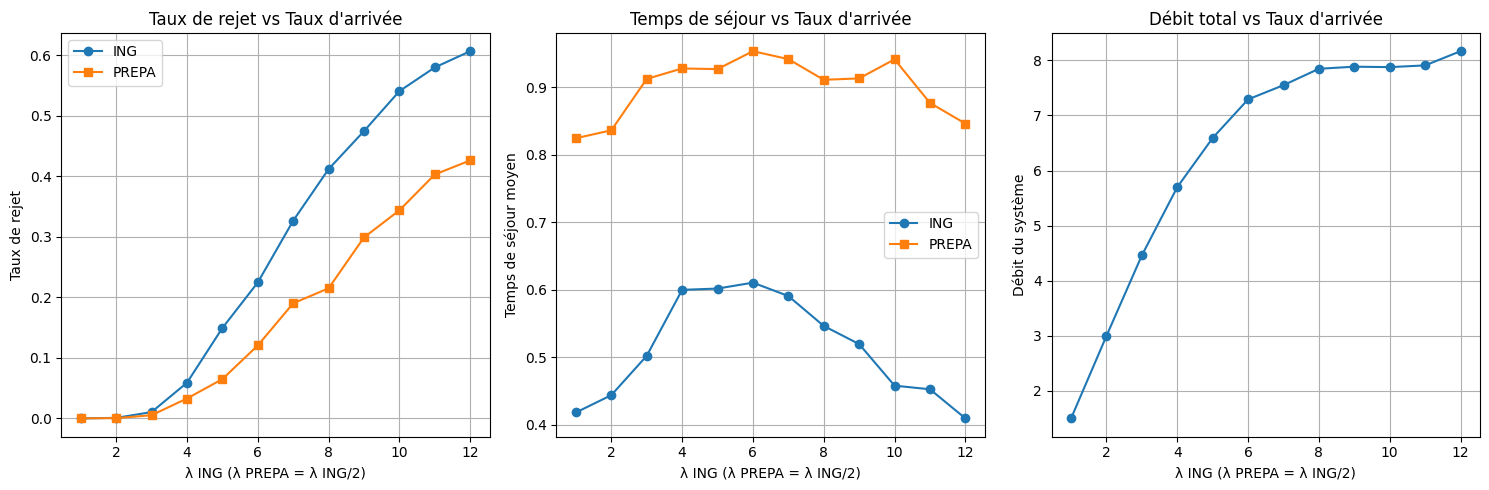


Point optimal (taux de rejet < 10%):
λ ING: 4.00
λ PREPA: 2.00
Taux de rejet ING: 5.9%
Taux de rejet PREPA: 3.3%


In [6]:
def benchmark_lambda_scaling(base_mu_ing=2.4, base_mu_prepa=1.2, k=4, ks=5, test_z=5000):
    """
    Benchmark qui augmente les valeurs de lambda tout en maintenant lambda_ing = 2*lambda_prepa
    """
    # Création d'une liste de valeurs de lambda à tester (lambda_ing sera deux fois ces valeurs)
    lambda_prepa_range = np.linspace(0.5, 6.0, 12)  # Test jusqu'à lambda_ing = 12
    
    results = []
    gen = np.random.default_rng(seed=42)
    
    for lambda_prepa in lambda_prepa_range:
        lambda_ing = 2 * lambda_prepa
        
        # Lance la simulation
        mmk_queue = mmk_finite_two_populations(
            lamda_ing=lambda_ing,
            lamda_prepa=lambda_prepa,
            mu_ing=base_mu_ing,
            mu_prepa=base_mu_prepa,
            k=k,
            Ks=ks,
            gen=gen,
            test_z=test_z
        )
        mmk_queue.run()
        stats = mmk_queue.stats()
        
        # Calcule les métriques d'efficacité
        ing_stats = stats[stats['Population'] == 'ING'].iloc[0]
        prepa_stats = stats[stats['Population'] == 'PREPA'].iloc[0]
        
        results.append({
            'lambda_ing': lambda_ing,
            'lambda_prepa': lambda_prepa,
            'rejection_rate_ing': ing_stats['Refused Pushes'] / (test_z/2),
            'rejection_rate_prepa': prepa_stats['Refused Pushes'] / (test_z/2),
            'sojourn_time_ing': ing_stats['Mean Sojourn Time'],
            'sojourn_time_prepa': prepa_stats['Mean Sojourn Time']
        })
    
    return pd.DataFrame(results)

# Lance le benchmark
results = benchmark_lambda_scaling()

# Crée des visualisations
plt.figure(figsize=(15, 5))

# Plot 1: Taux de rejet
plt.subplot(131)
plt.plot(results['lambda_ing'], results['rejection_rate_ing'], 
         marker='o', label='ING')
plt.plot(results['lambda_ing'], results['rejection_rate_prepa'], 
         marker='s', label='PREPA')
plt.xlabel('λ ING (λ PREPA = λ ING/2)')
plt.ylabel('Taux de rejet')
plt.title('Taux de rejet vs Taux d\'arrivée')
plt.legend()
plt.grid(True)

# Plot 2: Temps de séjour
plt.subplot(132)
plt.plot(results['lambda_ing'], results['sojourn_time_ing'], 
         marker='o', label='ING')
plt.plot(results['lambda_ing'], results['sojourn_time_prepa'], 
         marker='s', label='PREPA')
plt.xlabel('λ ING (λ PREPA = λ ING/2)')
plt.ylabel('Temps de séjour moyen')
plt.title('Temps de séjour vs Taux d\'arrivée')
plt.legend()
plt.grid(True)

# Plot 3: Métrique d'efficacité
plt.subplot(133)
results['total_throughput'] = (results['lambda_ing'] * (1 - results['rejection_rate_ing']) + 
                              results['lambda_prepa'] * (1 - results['rejection_rate_prepa']))
plt.plot(results['lambda_ing'], results['total_throughput'], marker='o')
plt.xlabel('λ ING (λ PREPA = λ ING/2)')
plt.ylabel('Débit du système')
plt.title('Débit total vs Taux d\'arrivée')
plt.grid(True)

plt.tight_layout()
plt.show()

# Trouver le point de fonctionnement optimal
acceptable_rejection = results[
    (results['rejection_rate_ing'] < 0.1) & 
    (results['rejection_rate_prepa'] < 0.1)
].iloc[-1]

print("\nPoint optimal (taux de rejet < 10%):")
print(f"λ ING: {acceptable_rejection['lambda_ing']:.2f}")
print(f"λ PREPA: {acceptable_rejection['lambda_prepa']:.2f}")
print(f"Taux de rejet ING: {acceptable_rejection['rejection_rate_ing']*100:.1f}%")
print(f"Taux de rejet PREPA: {acceptable_rejection['rejection_rate_prepa']*100:.1f}%")